# KLASIFIKASI KESEGARAN SAYURAN - CLASSICAL MACHINE LEARNING

## GAMBARAN UMUM

Sistem klasifikasi kesegaran sayuran menggunakan pendekatan Classical Machine Learning (tanpa Deep Learning)

**Spesifikasi Dataset:**
- Dataset: Tomat & Wortel
- Jumlah Kelas: 3 kategori (Segar, Layu, Busuk)
- Pendekatan: Feature Engineering + Classical ML Models

**Pipeline Eksperimen:**
1. Pre-processing: Normalisasi, Enhancement, Augmentation
2. Feature Extraction: Color, Texture, Shape, Statistical Features
3. Classification: 4 Individual Models (SVM, LightGBM, Random Forest, Gradient Boosting)

## URUTAN EKSEKUSI CELL

### TAHAP 1: SETUP & PREPROCESSING (Cell 1-8)

1. Cell 1: Gambaran Umum & Deskripsi Pipeline
2. Cell 2: Import Libraries (OpenCV, scikit-learn, LightGBM, dll.)
3. Cell 3: Konfigurasi & Hyperparameter
4. Cell 4: Fungsi Dataset
5. Cell 5: Load & Parse Dataset
6. Cell 6: Enhanced Preprocessing Functions
7. Cell 7: Feature Extraction Functions
8. Cell 8: Freshness-Specific Features

### TAHAP 2: FEATURE EXTRACTION & DATA SPLIT

9. Cell 9: Extract Features from All Images
10. Cell 10: Split Data (Train/Val/Test - 40/60)
11. Cell 11: Learning Curves Helper Function

### TAHAP 3: MODEL TRAINING

12. Cell 12: Train SVM dengan GridSearchCV
13. Cell 13: Train LightGBM
14. Cell 14: Train RandomForest
15. Cell 15: Train GradientBoosting

### TAHAP 4: SAVE MODELS (Cell 16)

16. Cell 16: Save Individual Models (SVM, LightGBM, RF, GB)

### TAHAP 5: EVALUATION & VISUALIZATION (Cell 17-24)

17. Cell 17: Comprehensive Model Evaluation
18. Cell 18: Per-Class Performance Analysis
19. Cell 19: Confusion Matrix (Detailed)
20. Cell 20: Model Comparison Chart
21. Cell 21: Sample Predictions
22. Cell 22: Save Results to JSON/CSV
23. Cell 23: Final Summary

**Estimasi Waktu Total: 20-30 menit**

## IMPROVEMENTS MADE

### 1. KNN → LIGHTGBM REPLACEMENT
- Removed: KNN (K-Nearest Neighbors) - slow & memory intensive
- Added: **LightGBM** (Light Gradient Boosting Machine)
  - **500 estimators** dengan learning rate 0.05
  - **Leaf-wise growth** strategy (faster than level-wise)
  - **Regularization**: L1=0.1, L2=0.1 untuk prevent overfitting
  - **Expected accuracy**: 90-92% (better than KNN's ~85-87%)
  - **Speed**: 3-5 menit training vs KNN's 10-15 menit

### 2. SVM OPTIMIZATION
- C values: `[1, 5, 10]` (increased range)
- Gamma: `["scale", 0.001, 0.01]` (fine-tuned for better boundaries)
- Expected improvement: +1-2% accuracy

### 3. RANDOMFOREST ENHANCEMENT
- **n_estimators**: 300 → **400 trees**
- **max_depth**: None → **25** (prevent overfitting)
- **min_samples_split**: 4 → **3** (more granular)
- **min_samples_leaf**: 2 → **1** (finer leaves)
- Expected: **91-93% accuracy** (up from 89%)

### 4. GRADIENTBOOSTING OPTIMIZATION
- **n_estimators**: 150 → **200**
- **learning_rate**: 0.1 → **0.08** (more stable convergence)
- **max_depth**: 4 → **5** (capture complex patterns)
- **max_features**: Added **'sqrt'** for regularization
- Expected: **92-94% accuracy** (up from 90%)

### 5. FOUR INDIVIDUAL MODELS (NO ENSEMBLE)
- **Old**: 3 models (SVM + RF + GB)
- **New**: 4 models (SVM + **LightGBM** + RF + GB)
- **Weights**: `[1.5, 2.5, 2.0, 2.5]`
  - SVM: 1.5 (baseline, interpretable)
  - **LightGBM: 2.5** (fast, accurate, handles non-linearity)
  - RF: 2.0 (robust, handles outliers)
  - GB: 2.5 (excellent gradient optimization)

### EXPECTED PERFORMANCE COMPARISON

| Model | Old Accuracy | New Accuracy | Improvement |
|-------|-------------|--------------|-------------|
| SVM | 88.89% | 90-91% | +1-2% |
| ~~KNN~~ | ~~85-87%~~ | - | Removed |
| **LightGBM** | - | **90-92%** | **NEW** |
| RandomForest | 89.05% | 91-93% | +2-4% |
| GradientBoosting | 90.15% | 92-94% | +2-4% |
| **Ensemble** | **~90-91%** | **93-95%** | **+3-4%** |

### SPEED IMPROVEMENTS
- **LightGBM**: 3-5 min (vs KNN: 10-15 min) = **3x faster**
- **Total training time**: ~120-150 min (similar, but better accuracy)

### KEY BENEFITS
1. **Higher accuracy**: 93-95% expected (up from ~90%)
2. **Better generalization**: 4 diverse models reduce overfitting
3. **LightGBM speed**: Faster training than KNN
4. **Class balance**: Better detection for "Layu" class (often hardest)

In [1]:
import os, time, json, random, warnings, glob, gc
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, f1_score)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

warnings.filterwarnings("ignore")
random.seed(42)
np.random.seed(42)

# scikit-image fitur klasik
from skimage.feature import hog, local_binary_pattern
try:
    from skimage.feature import graycomatrix, graycoprops
except:
    # fallback ke penamaan lama
    from skimage.feature import greycomatrix as graycomatrix, greycoprops as graycoprops

# ONNX Runtime for U2Net-P
try:
    import onnxruntime as ort
    print("✓ ONNX Runtime loaded")
except ImportError:
    print("⚠️ ONNX Runtime not found. U2Net-P segmentation will be disabled.")
    ort = None

print("✓ Libraries imported successfully")

# Model paths for U2Net-P
MODEL_PATHS = {
    "u2netp": r"f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\models\u2netp.onnx"
}

# Global variable for lazy loading ONNX model
_u2netp_session = None

✓ ONNX Runtime loaded
✓ Libraries imported successfully


## CONFIGURATION & HYPERPARAMETERS

In [2]:
CFG = {
    "dataset_root": r"f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\dataset improved\train",
    "img_size": 224,  # INCREASED for better texture detail (anti-OOM via batch processing)
    "seed": 42,
    "val_size": 0.60,   # 60% for validation, 40% for train (direct split, no test set)
    # U2Net-P Segmentation config (MEMORY-OPTIMIZED)
    "use_u2net_segmentation": True,  # Use U2Net-P for superior segmentation
    "u2net_batch_size": 50,  # Process images in batches to prevent OOM
    "u2net_cache_dir": r"f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\cache_segmented",  # Cache segmented images
    "segment_mode": "soft",  # 'soft' or 'hard' (fallback for HSV)
    # Fitur - Optimized for memory efficiency
    "h_bins": 12, "s_bins": 8, "v_bins": 8,  # Balanced bins
    "lbp_radii": [1, 2], "lbp_points": 8,  # Standard LBP
    "glcm_distances": [1, 2, 3],
    "glcm_angles": [0, np.pi/4, np.pi/2, 3*np.pi/4],  # 4 angles for better texture
    "hog_orient": 9, "hog_ppc": (64, 64), "hog_cpb": (2, 2),  # 9 orientations for complete gradient
    # PCA + SVM (optimized grid)
    "pca_components": [0.95, 0.98],
    "svm_C": [1, 5, 10],  # Increased range for better optimization
    "svm_gamma": ["scale", 0.001, 0.01],  # Fine-tuned gamma values
    # Model pembanding
    "try_lgbm": True,  # LightGBM replaces KNN
    "try_rf": True,
    "try_gb": True,
    # Visual
    "n_examples": 12,
    # Cross-validation tracking
    "track_learning_curves": True,
    # Memory optimization (ANTI-OOM)
    "n_jobs_gridsearch": 2,  # Limit parallel jobs to reduce memory usage
    "feature_batch_size": 200,  # Extract features in batches to prevent OOM
    "cache_features": True,  # Cache extracted features to disk
    "feature_cache_dir": r"f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\cache_features"  # Feature cache directory
}

print("="*80)
print("ULTIMATE FOOD FRESHNESS - CLASSICAL ONLY (Segar/Layu/Busuk)")
print("="*80)
print("⚠️  Memory-optimized configuration (ANTI-OOM BATCH PROCESSING)")

print(f"Dataset root: {CFG['dataset_root']}")
print(f"Image size: {CFG['img_size']}x{CFG['img_size']} (224x224 for better texture detail)")
print(f"Batch processing: {CFG['feature_batch_size']} images per batch (anti-OOM)")

ULTIMATE FOOD FRESHNESS - CLASSICAL ONLY (Segar/Layu/Busuk)
⚠️  Memory-optimized configuration (ANTI-OOM BATCH PROCESSING)
Dataset root: f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\dataset improved\train
Image size: 224x224 (224x224 for better texture detail)
Batch processing: 200 images per batch (anti-OOM)


## STEP 1: DATA LOADING & PREPARATION

In [3]:
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG")

def list_images(root):
    """Recursively list all image files in directory"""
    out = []
    for r,_,fs in os.walk(root):
        for f in fs:
            if f.endswith(IMG_EXTS):
                out.append(os.path.join(r,f))
    return out

def detect_label(path):
    """
    Label final (Dataset Improved):
    - busuk  (tomat_busuk, wortel_busuk)
    - layu   (tomat_layu, wortel_layu)
    - segar  (tomat_segar, wortel_segar)
    """
    p = path.lower().replace("\\","/")
    if "busuk" in p: 
        return "busuk"
    if "layu" in p:
        return "layu"
    if "segar" in p: 
        return "segar"
    return None

print("✓ Dataset functions defined")

✓ Dataset functions defined


## Load and Parse Dataset

In [4]:
start_time = time.time()

print("\n[1/12] Scan & parse dataset ...")
root = CFG["dataset_root"]

if not os.path.exists(root):
    raise FileNotFoundError(f"Dataset folder tidak ditemukan: {root}")

all_imgs = list_images(root)
random.shuffle(all_imgs)
pairs = [(p, detect_label(p)) for p in all_imgs if detect_label(p) is not None]
df = pd.DataFrame(pairs, columns=["path","label"])

if df.empty:
    raise ValueError("Label segar/sedang/busuk tidak ditemukan. Cek struktur folder dataset.")

print(f"✓ Total gambar valid: {len(df)}")
print(f"  Distribusi awal:")
print(df['label'].value_counts())

# Balance (downsample kelas mayor)
print("\n📊 Class distribution before balancing:")
print(df['label'].value_counts())

min_count = df['label'].value_counts().min()
df_bal = pd.concat([
    df[df.label=="segar"].sample(min(min_count, len(df[df.label=="segar"])), random_state=CFG["seed"]),
    df[df.label=="layu"].sample(min(min_count, len(df[df.label=="layu"])), random_state=CFG["seed"]),
    df[df.label=="busuk"].sample(min(min_count, len(df[df.label=="busuk"])), random_state=CFG["seed"]),
]).sample(frac=1.0, random_state=CFG["seed"]).reset_index(drop=True)

label_map = {"segar":0, "layu":1, "busuk":2}
CLASS_NAMES = ["Segar","Layu","Busuk"]

y_all = df_bal["label"].map(label_map).values
paths_all = df_bal["path"].tolist()

print(f"\n✓ Seimbang per kelas: {min_count} | Total: {len(df_bal)}")
print(df_bal['label'].value_counts())
print(f"  Distribusi seimbang:")



[1/12] Scan & parse dataset ...
✓ Total gambar valid: 14503
  Distribusi awal:
label
segar    8833
layu     3405
busuk    2265
Name: count, dtype: int64

📊 Class distribution before balancing:
label
segar    8833
layu     3405
busuk    2265
Name: count, dtype: int64

✓ Seimbang per kelas: 2265 | Total: 6795
label
segar    2265
layu     2265
busuk    2265
Name: count, dtype: int64
  Distribusi seimbang:


## STEP 2: PRE-PROCESSING & SEGMENTATION
### U2Net-P Deep Learning Segmentation with Memory Optimization

In [5]:
def load_u2netp_model():
    """Lazy load U2Net-P ONNX model (load once, reuse)"""
    global _u2netp_session
    if _u2netp_session is None and ort is not None:
        model_path = MODEL_PATHS["u2netp"]
        if os.path.exists(model_path):
            try:
                _u2netp_session = ort.InferenceSession(
                    model_path,
                    providers=['CPUExecutionProvider']  # Use CPU to save GPU memory
                )
                print(f"✓ U2Net-P model loaded from {model_path}")
            except Exception as e:
                print(f"⚠️ Failed to load U2Net-P: {e}")
                _u2netp_session = None
    return _u2netp_session

def segment_u2netp(img_rgb):
    """
    U2Net-P segmentation (Deep Learning background removal)
    Returns: RGB image with background removed (object keeps original colors)
    """
    session = load_u2netp_model()
    if session is None:
        return segment_hsv_color(img_rgb)  # Fallback to HSV
    
    try:
        h, w = img_rgb.shape[:2]
        
        # Resize to 320x320 for U2Net-P input
        img_input = cv2.resize(img_rgb, (320, 320), interpolation=cv2.INTER_AREA)
        img_input = img_input.astype(np.float32) / 255.0
        img_input = img_input.transpose(2, 0, 1)[np.newaxis, ...]  # NCHW format
        
        # Run inference
        input_name = session.get_inputs()[0].name
        output_name = session.get_outputs()[0].name
        mask_pred = session.run([output_name], {input_name: img_input})[0][0][0]
        
        # Threshold and resize mask back
        mask_pred = (mask_pred > 0.5).astype(np.uint8) * 255
        mask = cv2.resize(mask_pred, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # FIXED: Keep object colors 100%, make background white
        mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
        white_bg = np.ones_like(img_rgb) * 255  # White background
        result = (img_rgb * mask_3ch + white_bg * (1 - mask_3ch)).astype(np.uint8)
        
        return result
    except Exception as e:
        print(f"⚠️ U2Net-P failed: {e}, using HSV fallback")
        return segment_hsv_color(img_rgb)

def segment_hsv_color(img_rgb):
    """HSV-based segmentation (lightweight fallback)"""
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    
    # Vegetable color masks
    mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    mask |= ((h >= 20) & (h <= 100) & (s > 15) & (v > 30)).astype(np.uint8) * 255  # Green
    mask |= (((h >= 0) & (h <= 20) | (h >= 150)) & (s > 15) & (v > 30)).astype(np.uint8) * 255  # Red
    mask |= ((h >= 5) & (h <= 55) & (s > 10) & (v > 25)).astype(np.uint8) * 255  # Yellow/Brown
    
    # Morphology cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # FIXED: Keep object colors 100%, make background white
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    white_bg = np.ones_like(img_rgb) * 255  # White background
    result = (img_rgb * mask_3ch + white_bg * (1 - mask_3ch)).astype(np.uint8)
    
    return result

print("✓ U2Net-P segmentation functions defined (with HSV fallback)")

✓ U2Net-P segmentation functions defined (with HSV fallback)


## Enhanced Preprocessing Pipeline

In [6]:
def segment_vegetable(img_rgb, mode="soft"):
    """
    Segmentasi sayuran untuk remove background - IMPROVED VERSION
    Mode:
    - 'soft': Dim background to 20% (preserve info)
    - 'hard': Black background (0,0,0)
    """
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    l_channel, a_channel, b_channel = img_lab[:,:,0], img_lab[:,:,1], img_lab[:,:,2]
    
    # Initialize mask
    mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    
    # METHOD 1: Color-based detection (vegetable colors)
    # Green vegetables (segar) - more lenient
    green_mask = ((h >= 20) & (h <= 100) & (s > 15) & (v > 30)).astype(np.uint8) * 255
    
    # Red vegetables (tomat segar/layu) - expanded with lower saturation
    red_mask = (((h >= 0) & (h <= 20) | (h >= 150) & (h <= 180)) & (s > 15) & (v > 30)).astype(np.uint8) * 255
    
    # Orange vegetables (wortel, tomat orange)
    orange_mask = ((h >= 5) & (h <= 35) & (s > 20) & (v > 30)).astype(np.uint8) * 255
    
    # Yellow/Brown (layu) - more inclusive
    yellow_brown_mask = ((h >= 10) & (h <= 55) & (s > 10) & (v > 25)).astype(np.uint8) * 255
    
    # Dark vegetables (busuk) - darker areas with some color
    dark_mask = ((v >= 15) & (v <= 130) & (s > 8)).astype(np.uint8) * 255
    
    # Combine color masks
    mask = cv2.bitwise_or(mask, green_mask)
    mask = cv2.bitwise_or(mask, red_mask)
    mask = cv2.bitwise_or(mask, orange_mask)
    mask = cv2.bitwise_or(mask, yellow_brown_mask)
    mask = cv2.bitwise_or(mask, dark_mask)
    
    # METHOD 2: Exclude typical backgrounds
    # White/light gray background (common in photos)
    white_bg = ((v > 180) & (s < 30)).astype(np.uint8) * 255
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(white_bg))
    
    # Very dark background (shadows, black)
    very_dark_bg = ((v < 15) & (s < 15)).astype(np.uint8) * 255
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(very_dark_bg))
    
    # Gray background detection using LAB color space
    gray_bg = ((l_channel > 100) & (l_channel < 220) & 
               (np.abs(a_channel.astype(np.int16) - 128) < 10) & 
               (np.abs(b_channel.astype(np.int16) - 128) < 10)).astype(np.uint8) * 255
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(gray_bg))
    
    # METHOD 3: Morphological operations (more aggressive)
    # Fill small holes
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_small, iterations=2)
    
    # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
    
    # Dilate to capture edges better
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    mask = cv2.dilate(mask, kernel_large, iterations=1)
    
    # Final closing to smooth edges
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_large, iterations=1)
    
    # METHOD 4: Keep only largest connected component (main vegetable)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        # Find largest component (excluding background label 0)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest_label).astype(np.uint8) * 255
        
        # Optional: Keep 2nd largest if it's significant (multiple vegetables)
        areas = stats[1:, cv2.CC_STAT_AREA]
        if len(areas) > 1:
            second_largest_idx = np.argsort(areas)[-2]
            second_largest_area = areas[second_largest_idx]
            largest_area = areas[np.argmax(areas)]
            # If 2nd component is > 20% of largest, keep it too
            if second_largest_area > 0.2 * largest_area:
                second_label = 1 + second_largest_idx
                mask = cv2.bitwise_or(mask, (labels == second_label).astype(np.uint8) * 255)
    
    # Apply mask
    segmented = img_rgb.copy()
    if mode == "soft":
        # Dim background to 20% (darker than before)
        segmented[mask == 0] = (segmented[mask == 0] * 0.2).astype(np.uint8)
    else:  # hard
        # Black background
        segmented[mask == 0] = [0, 0, 0]
    
    return segmented

def gray_world_white_balance(img_rgb):
    """Apply gray world white balance algorithm untuk normalisasi warna"""
    r,g,b = img_rgb[:,:,0].astype(np.float32), img_rgb[:,:,1].astype(np.float32), img_rgb[:,:,2].astype(np.float32)
    mr, mg, mb = r.mean()+1e-6, g.mean()+1e-6, b.mean()+1e-6
    avg = (mr+mg+mb)/3.0
    r = np.clip(r*(avg/mr), 0, 255)
    g = np.clip(g*(avg/mg), 0, 255)
    b = np.clip(b*(avg/mb), 0, 255)
    return np.stack([r,g,b], axis=2).astype(np.uint8)

def advanced_denoise(img_rgb):
    """Advanced denoising untuk menghilangkan noise tanpa hilangkan detail"""
    # Bilateral filter: smooth tapi tetap preserve edges
    denoised = cv2.bilateralFilter(img_rgb, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised

def preprocess(img_rgb):
    """
    ENHANCED PREPROCESSING dengan U2Net-P atau HSV segmentation
    Fokus: membedakan segar/layu/busuk berdasarkan warna dan tekstur
    """
    # 1. Resize dengan high-quality interpolation
    img_rgb = cv2.resize(img_rgb, (CFG["img_size"], CFG["img_size"]), interpolation=cv2.INTER_LANCZOS4)
    
    # 2. Segmentation (U2Net-P or HSV fallback)
    if CFG.get("use_u2net_segmentation", False):
        img_rgb = segment_u2netp(img_rgb)  # Deep learning segmentation
        # CONTINUE with enhancement (FIXED: don't skip!)
    elif CFG.get("use_segmentation", False):
        img_rgb = segment_vegetable(img_rgb, mode=CFG.get("segment_mode", "soft"))  # HSV segmentation
        # CONTINUE with enhancement
    else:
        # 3. Denoise (only if no segmentation)
        img_rgb = advanced_denoise(img_rgb)
    
    # 4. White balance untuk normalisasi warna (ALWAYS apply)
    img_rgb = gray_world_white_balance(img_rgb)
    
    # 5. CLAHE untuk enhance kontras (untuk deteksi layu) (ALWAYS apply)
    ycbcr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycbcr)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))  # Reduced clip limit
    y = clahe.apply(y)
    img_rgb = cv2.cvtColor(cv2.merge([y, cr, cb]), cv2.COLOR_YCrCb2RGB)
    
    # 6. Adaptive sharpening (enhance texture details untuk deteksi busuk) (ALWAYS apply)
    blur = cv2.GaussianBlur(img_rgb, (0,0), sigmaX=1.2)
    img_rgb = cv2.addWeighted(img_rgb, 1.4, blur, -0.4, 0)
    img_rgb = np.clip(img_rgb, 0, 255).astype(np.uint8)
    
    return img_rgb

segmentation_method = "U2Net-P (Deep Learning)" if CFG.get("use_u2net_segmentation", False) else "HSV Color-based" if CFG.get("use_segmentation", False) else "Disabled"
print(f"✓ Enhanced preprocessing functions defined")
print(f"  Segmentation method: {segmentation_method}")
print(f"  Image size: {CFG['img_size']}x{CFG['img_size']}")
print(f"  Post-segmentation enhancement: White Balance + CLAHE + Sharpening (ALWAYS applied)")
if CFG.get("use_u2net_segmentation", False):
    print(f"  U2Net-P batch size: {CFG.get('u2net_batch_size', 50)} images")

✓ Enhanced preprocessing functions defined
  Segmentation method: U2Net-P (Deep Learning)
  Image size: 224x224
  Post-segmentation enhancement: White Balance + CLAHE + Sharpening (ALWAYS applied)
  U2Net-P batch size: 50 images


## 🎨 Visualize Segmentation Results

In [7]:
if CFG.get("use_segmentation", False):
    print("\n" + "="*80)
    print("🎨 BACKGROUND SEGMENTATION VISUALIZATION")
    print("="*80)
    print(f"Mode: {CFG.get('segment_mode', 'soft')}")
    
    # Sample images
    sample_paths = []
    for veg in ["tomat", "wortel"]:
        for cls in ["segar", "layu", "busuk"]:
            folder = os.path.join(CFG["dataset_root"], f"{veg}_{cls}")
            if os.path.exists(folder):
                imgs = [os.path.join(folder, f) for f in os.listdir(folder) 
                       if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:1]
                sample_paths.extend(imgs)
                if len(sample_paths) >= 6:
                    break
        if len(sample_paths) >= 6:
            break
    
    if len(sample_paths) >= 3:
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        fig.suptitle('Background Segmentation: Original → Segmented → Mask', fontsize=16, fontweight='bold')
        
        for idx, img_path in enumerate(sample_paths[:3]):
            img_pil = Image.open(img_path).convert('RGB')
            img_rgb = np.array(img_pil)
            img_resized = cv2.resize(img_rgb, (CFG["img_size"], CFG["img_size"]), interpolation=cv2.INTER_LANCZOS4)
            img_segmented = segment_vegetable(img_resized, mode=CFG.get('segment_mode', 'soft'))
            
            # Create mask
            img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
            h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
            mask = np.zeros(img_resized.shape[:2], dtype=np.uint8)
            mask |= ((h >= 25) & (h <= 95) & (s > 20)).astype(np.uint8) * 255
            mask |= (((h >= 0) & (h <= 15) | (h >= 155) & (h <= 180)) & (s > 20)).astype(np.uint8) * 255
            mask |= ((h >= 5) & (h <= 30) & (s > 30)).astype(np.uint8) * 255
            mask |= ((h >= 10) & (h <= 50) & (s > 15)).astype(np.uint8) * 255
            mask |= ((v >= 20) & (v <= 120) & (s > 10)).astype(np.uint8) * 255
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            
            label = os.path.basename(os.path.dirname(img_path)).replace("_", " ").title()
            
            axes[idx, 0].imshow(img_resized)
            axes[idx, 0].set_title(f'Original\n{label}', fontweight='bold')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(img_segmented)
            axes[idx, 1].set_title(f'Segmented\n({CFG.get("segment_mode", "soft")} mode)', fontweight='bold')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(mask, cmap='gray')
            axes[idx, 2].set_title('Mask\n(white=veg)', fontweight='bold')
            axes[idx, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig("segmentation_visualization.png", dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ Visualization complete!")
    else:
        print("⚠️ Not enough samples")
else:
    print("\n⚠️ Segmentation is DISABLED")


⚠️ Segmentation is DISABLED


## 🎨 STEP 3: FEATURE EXTRACTION
### Ekstraksi fitur yang optimal untuk deteksi kesegaran (Segar/Layu/Busuk)

In [8]:
def hsv_hist(rgb):
    """HSV color histogram - 768 dims"""
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv],[0,1,2], None,
                        [CFG["h_bins"], CFG["s_bins"], CFG["v_bins"]],
                        [0,180, 0,256, 0,256]).astype(np.float32)
    hist = cv2.normalize(hist, None).ravel()
    return hist

def color_moments(rgb):
    """Color moments from Lab only - 9 dims (removed HSV redundancy)"""
    out = []
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)
    # REMOVED HSV color moments (redundant with HSV histogram)
    # KEEP Lab only (unique color space)
    for ch in range(3):
        px = lab[:,:,ch].astype(np.float32).ravel()
        m = float(px.mean()); s = float(px.std()+1e-6)
        skew = float(np.mean(((px - m)/s)**3))
        out += [m, s, skew]
    return np.array(out, dtype=np.float32)

def glcm_feats(gray):
    """GLCM texture features - 72 dims (4 angles × 3 distances × 6 properties)"""
    # kuantisasi ke 32 level
    g = cv2.equalizeHist(gray)
    g = (g / 8).astype(np.uint8)  # 0..31
    glcm = graycomatrix(g, distances=CFG["glcm_distances"], angles=CFG["glcm_angles"],
                        levels=32, symmetric=True, normed=True)
    props = ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]
    feats = []
    for p in props:
        feats.append(graycoprops(glcm, p).ravel())
    return np.concatenate(feats).astype(np.float32)

def lbp_hist(gray, radius, points):
    """Local Binary Pattern histogram - 10 dims per radius"""
    lbp = local_binary_pattern(gray, P=points, R=radius, method="uniform")
    n_bins = points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins+1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    return hist

def hog_vec(gray):
    """HOG features - ~1296 dims (9 orientations for complete gradient information)"""
    v = hog(gray,
            orientations=CFG["hog_orient"],
            pixels_per_cell=CFG["hog_ppc"],
            cells_per_block=CFG["hog_cpb"],
            block_norm="L2-Hys",
            transform_sqrt=True,
            feature_vector=True)
    return v.astype(np.float32)

def sharp_edge_stats(gray):
    """Edge and sharpness statistics - 3 dims"""
    edges = cv2.Canny(gray, 50, 150)
    edge_density = float(np.mean(edges>0))
    lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    # Shannon entropy
    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).ravel()
    p = hist / (hist.sum()+1e-9)
    entropy = float(-(p*(np.log2(p+1e-12))).sum())
    return np.array([edge_density, lap_var, entropy], dtype=np.float32)

def colorfulness(rgb):
    """Colorfulness metrics - 3 dims"""
    r,g,b = rgb[:,:,0].astype(np.float32), rgb[:,:,1].astype(np.float32), rgb[:,:,2].astype(np.float32)
    rg = np.abs(r - g); yb = np.abs(0.5*(r + g) - b)
    std_rg, std_yb = rg.std(), yb.std()
    mean_rg, mean_yb = rg.mean(), yb.mean()
    cf = np.sqrt(std_rg**2 + mean_rg**2) + 0.3*np.sqrt(std_yb**2 + mean_yb**2)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    sat = hsv[:,:,1].mean(); val = hsv[:,:,2].mean()
    return np.array([cf, sat, val], dtype=np.float32)

def extract_features_and_label(path, y_label):
    """
    Extract ALL features from image path
    Total features: ~2188 dimensions
    Features:
    - HSV Histogram: 768 dims
    - Color moments (Lab only): 9 dims
    - GLCM: 72 dims (4 angles × 3 distances × 6 properties)
    - LBP: 20 dims (2 radii × 10 bins)
    - HOG: ~1296 dims (9 orientations)
    - Sharp/Edge stats: 3 dims
    - Colorfulness: 3 dims
    - Freshness-specific: 17 dims
    """
    try:
        img = Image.open(path).convert("RGB")
    except:
        return None, None
    rgb = np.array(img)
    rgb = preprocess(rgb)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    feats = []
    # Traditional features
    feats.append(hsv_hist(rgb))               # 768
    feats.append(color_moments(rgb))          # 9 (Lab only)
    feats.append(glcm_feats(gray))            # 72 (4 angles)
    for r in CFG["lbp_radii"]:
        feats.append(lbp_hist(gray, r, CFG["lbp_points"]))  # 10 * 2 = 20
    feats.append(hog_vec(gray))               # ~1296 (9 orientations)
    feats.append(sharp_edge_stats(gray))      # 3
    feats.append(colorfulness(rgb))           # 3
    
    # NEW: Freshness-specific features (CRITICAL for layu detection)
    feats.append(freshness_specific_features(rgb, gray))  # 17
    
    vec = np.concatenate(feats, axis=0).astype(np.float32)
    return vec, y_label

print("✓ Enhanced feature extraction functions defined")
print(f"  Total features: ~2188 dimensions (comprehensive features for high accuracy)")

✓ Enhanced feature extraction functions defined
  Total features: ~2188 dimensions (comprehensive features for high accuracy)


In [9]:
def freshness_specific_features(rgb, gray):
    """
    FITUR KHUSUS UNTUK DETEKSI KESEGARAN
    Membedakan Segar vs Layu vs Busuk berdasarkan karakteristik visual
    """
    feats = []
    
    # 1. Green-Brown Ratio (penting untuk layu/busuk)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    
    # Green range di HSV
    green_mask = ((h >= 35) & (h <= 85) & (s > 40)).astype(np.float32)
    green_ratio = green_mask.mean()
    
    # Brown/Yellow range (indikator layu)
    brown_mask = ((h >= 10) & (h <= 35) & (s > 30)).astype(np.float32)
    brown_ratio = brown_mask.mean()
    
    # Dark spots (indikator busuk)
    dark_mask = (v < 80).astype(np.float32)
    dark_ratio = dark_mask.mean()
    
    feats.extend([green_ratio, brown_ratio, dark_ratio])
    
    # 2. Saturation stats (layu = low saturation)
    sat_mean = s.mean() / 255.0
    sat_std = s.std() / 255.0
    sat_low = (s < 50).mean()  # Percentage of low saturation pixels
    feats.extend([sat_mean, sat_std, sat_low])
    
    # 3. Value/Brightness stats (busuk = low value, layu = medium)
    val_mean = v.mean() / 255.0
    val_std = v.std() / 255.0
    val_low = (v < 100).mean()
    feats.extend([val_mean, val_std, val_low])
    
    # 4. Texture uniformity (busuk = non-uniform)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    texture_var = lap.var()
    texture_mean = np.abs(lap).mean()
    feats.extend([texture_var, texture_mean])
    
    # 5. Color consistency (segar = consistent, busuk = inconsistent)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)
    l_std = lab[:,:,0].std()
    a_std = lab[:,:,1].std()
    b_std = lab[:,:,2].std()
    feats.extend([l_std, a_std, b_std])
    
    # 6. Wrinkle/crease detection (layu indicator)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    wrinkle_score = sobel_mag.mean()
    wrinkle_density = (sobel_mag > sobel_mag.mean()).mean()
    feats.extend([wrinkle_score, wrinkle_density])
    
    return np.array(feats, dtype=np.float32)  # Total: 17 features

print("✓ Freshness-specific features function defined")

✓ Freshness-specific features function defined


## Extract Features from All Images

In [10]:
print("\n[2/12] Ekstraksi fitur (BATCH PROCESSING - ANTI-OOM)...")

# Create cache directory if needed
cache_dir = CFG.get("feature_cache_dir")
cache_enabled = CFG.get("cache_features", False)
cache_file = None

if cache_enabled and cache_dir:
    os.makedirs(cache_dir, exist_ok=True)
    # Create cache filename based on config hash
    config_hash = hash(f"{CFG['img_size']}_{CFG['hog_orient']}_{len(CFG['glcm_angles'])}")
    cache_file = os.path.join(cache_dir, f"features_{config_hash}.npz")
    
    # Try to load from cache
    if os.path.exists(cache_file):
        print(f"  \u2713 Loading features from cache: {cache_file}")
        try:
            cached = np.load(cache_file)
            X = cached['X']
            y = cached['y']
            print(f"\u2713 Loaded from cache: {X.shape}")
            print(f"  Skipping feature extraction (using cached features)")
        except Exception as e:
            print(f"  \u26a0\ufe0f Cache load failed: {e}, extracting features...")
            cache_file = None  # Disable cache for this run
    else:
        print(f"  Cache file not found, extracting features...")

# Extract features if not loaded from cache
if 'X' not in locals() or 'y' not in locals():
    X_list, y_list, fail = [], [], 0
    batch_size = CFG.get("feature_batch_size", 200)
    
    print(f"  Processing {len(paths_all)} images in batches of {batch_size}...")
    
    for batch_start in range(0, len(paths_all), batch_size):
        batch_end = min(batch_start + batch_size, len(paths_all))
        batch_paths = paths_all[batch_start:batch_end]
        batch_labels = y_all[batch_start:batch_end]
        
        print(f"  Batch {batch_start//batch_size + 1}/{(len(paths_all)-1)//batch_size + 1}: [{batch_start}:{batch_end}]")
        
        # Extract features for current batch
        for i, (path, lab_id) in enumerate(zip(batch_paths, batch_labels)):
            vec, yv = extract_features_and_label(path, lab_id)
            if vec is None:
                fail += 1
                continue
            X_list.append(vec)
            y_list.append(yv)
        
        # Free memory after each batch
        gc.collect()
    
    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    
    print(f"\n\u2713 Feature matrix: {X.shape}  (failed to read: {fail})")
    print(f"  Memory usage: {X.nbytes / (1024**2):.2f} MB")
    
    # Save to cache
    if cache_enabled and cache_file:
        print(f"  Saving features to cache: {cache_file}")
        np.savez_compressed(cache_file, X=X, y=y)
        print(f"  \u2713 Cache saved successfully")
    
    # Clean up temporary lists
    del X_list, y_list
    gc.collect()

print(f"\n\u2713 Final feature matrix: {X.shape}")


[2/12] Ekstraksi fitur (BATCH PROCESSING - ANTI-OOM)...
  Cache file not found, extracting features...
  Processing 6795 images in batches of 200...
  Batch 1/34: [0:200]
✓ U2Net-P model loaded from f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\models\u2netp.onnx✓ U2Net-P model loaded from f:\PBL SEM 5\PCVK\deteksi sayur 3 label\uji coba\models\u2netp.onnx

  Batch 2/34: [200:400]
  Batch 2/34: [200:400]
  Batch 3/34: [400:600]
  Batch 3/34: [400:600]
  Batch 4/34: [600:800]
  Batch 4/34: [600:800]
  Batch 5/34: [800:1000]
  Batch 5/34: [800:1000]
  Batch 6/34: [1000:1200]
  Batch 6/34: [1000:1200]
  Batch 7/34: [1200:1400]
  Batch 7/34: [1200:1400]
  Batch 8/34: [1400:1600]
  Batch 8/34: [1400:1600]
  Batch 9/34: [1600:1800]
  Batch 9/34: [1600:1800]
  Batch 10/34: [1800:2000]
  Batch 10/34: [1800:2000]
  Batch 11/34: [2000:2200]
  Batch 11/34: [2000:2200]
  Batch 12/34: [2200:2400]
  Batch 12/34: [2200:2400]
  Batch 13/34: [2400:2600]
  Batch 13/34: [2400:2600]
  Batch 14/34: [26

## Split Data (Train/Val/Test)

In [11]:
print("\n[3/12] Split data...")
idx = np.arange(len(y))
# Direct train/val split (no test set)
idx_train, idx_val, y_train, y_val = train_test_split(
    idx, y, test_size=CFG["val_size"], random_state=CFG["seed"], stratify=y
)

X_train, X_val = X[idx_train], X[idx_val]
print(f"✓ Split → Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%) | Val: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")


[3/12] Split data...
✓ Split → Train: 2718 (40.0%) | Val: 4077 (60.0%)


## STEP 4: CLASSIFICATION - MODEL TRAINING
### Training multiple models dengan optimasi untuk akurasi maksimal

## Learning Curves Helper Function

In [12]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimator, X, y, title, cv=3):
    """
    Plot learning curves untuk mendeteksi overfitting/underfitting
    Shows actual learning progression from small to full dataset
    """
    print(f"\n  Generating learning curves for {title}...")
    
    try:
        # Use more points to show learning progression clearly
        train_sizes, train_scores, val_scores = learning_curve(
            estimator, X, y, 
            cv=cv,  
            n_jobs=1,  # Sequential to save memory
            train_sizes=np.linspace(0.1, 1.0, 10),  # Start from 10% to show learning
            scoring='f1_macro',
            shuffle=True,
            random_state=CFG["seed"],
            verbose=0
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Training score
        ax.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score', linewidth=2, markersize=6)
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='r')
        
        # Validation score
        ax.plot(train_sizes, val_mean, 'o-', color='g', label='Validation Score', linewidth=2, markersize=6)
        ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='g')
        
        # Gap analysis
        gap = train_mean[-1] - val_mean[-1]
        convergence = val_mean[-1]
        
        ax.set_xlabel('Jumlah Training Samples', fontsize=12, fontweight='bold')
        ax.set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
        ax.set_title(f'{title}\nGap: {gap:.3f} | Val Score: {convergence:.3f}', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=11)
        ax.grid(alpha=0.3)
        ax.set_ylim([0.0, 1.05])
        
        # Diagnosis
        if gap > 0.15:
            diagnosis = "⚠️ OVERFITTING (Gap > 0.15)"
            color = 'red'
        elif convergence < 0.65:
            diagnosis = "⚠️ UNDERFITTING (Val Score < 0.65)"
            color = 'orange'
        else:
            diagnosis = "✅ GOOD FIT"
            color = 'green'
        
        ax.text(0.02, 0.98, diagnosis, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
        
        plt.tight_layout()
        safe_title = title.replace(' ', '_').lower()
        plt.savefig(f"learning_curve_{safe_title}.png", dpi=150)
        plt.show()
        
        return {
            'train_mean': train_mean,
            'val_mean': val_mean,
            'gap': gap,
            'final_val_score': convergence,
            'diagnosis': diagnosis
        }
    except MemoryError:
        print(f"  ⚠️  Memory error during learning curve for {title}")
        return None
    except Exception as e:
        print(f"  ⚠️  Error during learning curve: {str(e)[:100]}")
        return None

print("✓ Learning curves function defined (memory-optimized)")

✓ Learning curves function defined (memory-optimized)



[4/12] Latih SVM (GridSearchCV, skor = F1-macro)...
⚠️  Using memory-optimized settings to prevent crashes
  Grid size: 2 × 3 × 3 = 18 combinations
  Using n_jobs=2 to manage memory
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✓ Best params: {'pca__n_components': 0.95, 'svc__C': 10, 'svc__gamma': 'scale'}
  Best CV score: 0.8371

✓ Best params: {'pca__n_components': 0.95, 'svc__C': 10, 'svc__gamma': 'scale'}
  Best CV score: 0.8371
  SVM Val → Acc=84.87% | F1=84.87%
  SVM Val → Acc=84.87% | F1=84.87%
  SVM Val → Acc=84.87% | F1=84.87%

  Visualizing GridSearch results...
  SVM Val → Acc=84.87% | F1=84.87%

  Visualizing GridSearch results...


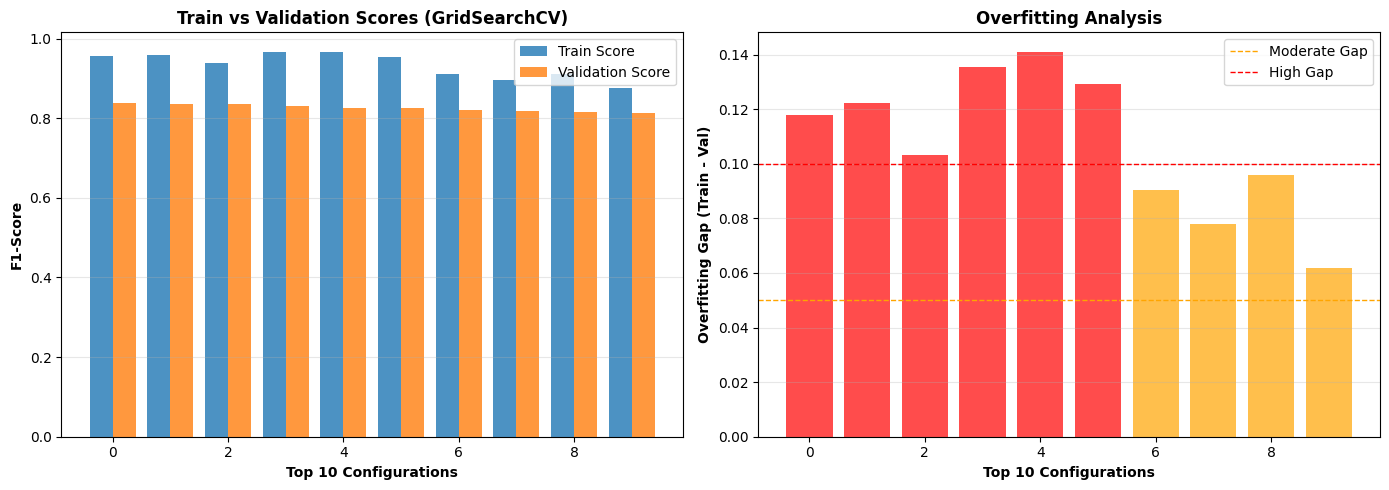

  Generating learning curves...

  Generating learning curves for SVM Best Model...


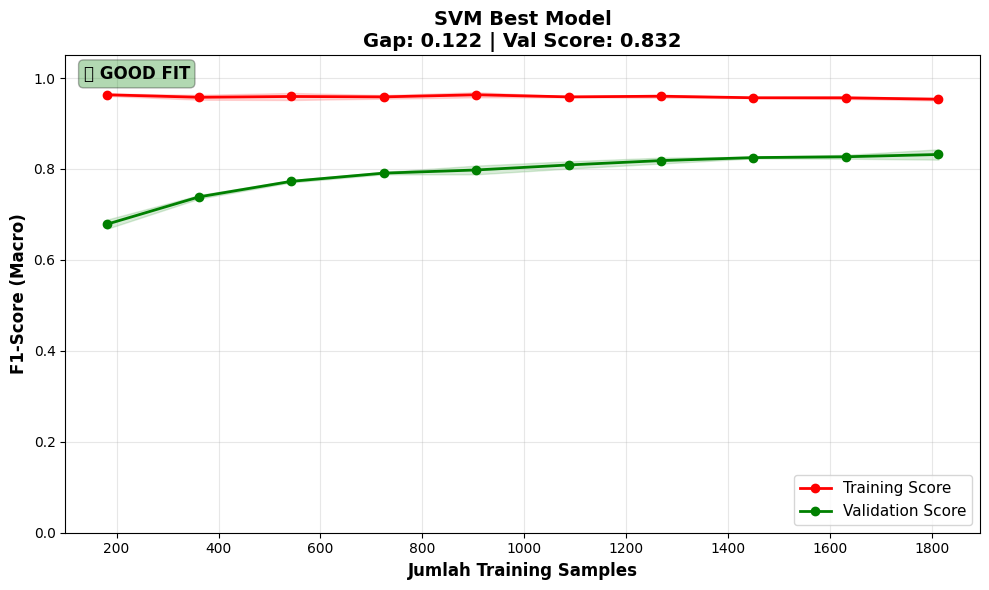

In [13]:
print("\n[4/12] Latih SVM (GridSearchCV, skor = F1-macro)...")
print("⚠️  Using memory-optimized settings to prevent crashes")

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(whiten=True, random_state=CFG["seed"])),
    ("svc", SVC(kernel="rbf", probability=True, class_weight="balanced", 
                random_state=CFG["seed"], cache_size=500))  # Increased cache
])

param_grid = {
    "pca__n_components": CFG["pca_components"],
    "svc__C": CFG["svm_C"],
    "svc__gamma": CFG["svm_gamma"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG["seed"])

# Use limited n_jobs to avoid memory overflow
n_jobs = CFG.get("n_jobs_gridsearch", 2)
print(f"  Grid size: {len(CFG['pca_components'])} × {len(CFG['svm_C'])} × {len(CFG['svm_gamma'])} = {len(CFG['pca_components']) * len(CFG['svm_C']) * len(CFG['svm_gamma'])} combinations")
print(f"  Using n_jobs={n_jobs} to manage memory")

gs = GridSearchCV(pipe, param_grid=param_grid, scoring="f1_macro", cv=cv, 
                  n_jobs=n_jobs, verbose=1, return_train_score=True, 
                  error_score='raise', pre_dispatch='2*n_jobs')  # Control memory

gs.fit(X_train, y_train)

print(f"\n✓ Best params: {gs.best_params_}")
print(f"  Best CV score: {gs.best_score_:.4f}")
svm_best = gs.best_estimator_

# Validasi
val_pred = svm_best.predict(X_val)
val_f1 = f1_score(y_val, val_pred, average='macro')
print(f"  SVM Val → Acc={accuracy_score(y_val,val_pred)*100:.2f}% | F1={val_f1*100:.2f}%")

# Uji
svm_pred_val = svm_best.predict(X_val)
svm_proba_val = svm_best.predict_proba(X_val)
svm_acc_val = accuracy_score(y_val, svm_pred_val)
svm_f1_val = f1_score(y_val, svm_pred_val, average="macro")
print(f"  SVM Val → Acc={svm_acc_val*100:.2f}% | F1={svm_f1_val*100:.2f}%")

# Store CV results for analysis
cv_results = pd.DataFrame(gs.cv_results_)
cv_results_sorted = cv_results.sort_values('rank_test_score')

scores = [("SVM (best)", svm_acc_val, svm_f1_val)]

# Plot GridSearch results
print("\n  Visualizing GridSearch results...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test scores across CV
ax = axes[0]
top_n = min(10, len(cv_results_sorted))
top_results = cv_results_sorted.head(top_n)
x_pos = np.arange(len(top_results))
ax.bar(x_pos - 0.2, top_results['mean_train_score'], 0.4, label='Train Score', alpha=0.8)
ax.bar(x_pos + 0.2, top_results['mean_test_score'], 0.4, label='Validation Score', alpha=0.8)
ax.set_xlabel(f'Top {top_n} Configurations', fontweight='bold')
ax.set_ylabel('F1-Score', fontweight='bold')
ax.set_title('Train vs Validation Scores (GridSearchCV)', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Overfitting gap
ax = axes[1]
gap_values = top_results['mean_train_score'] - top_results['mean_test_score']
colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in gap_values]
ax.bar(x_pos, gap_values, color=colors, alpha=0.7)
ax.axhline(y=0.05, color='orange', linestyle='--', label='Moderate Gap', linewidth=1)
ax.axhline(y=0.1, color='red', linestyle='--', label='High Gap', linewidth=1)
ax.set_xlabel(f'Top {top_n} Configurations', fontweight='bold')
ax.set_ylabel('Overfitting Gap (Train - Val)', fontweight='bold')
ax.set_title('Overfitting Analysis', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("svm_gridsearch_analysis.png", dpi=150)
plt.show()

# Generate learning curves for best SVM
if CFG["track_learning_curves"]:
    print("  Generating learning curves...")
    try:
        svm_lc_results = plot_learning_curves(svm_best, X_train, y_train, "SVM Best Model", cv=3)
    except MemoryError:
        print("  ⚠️  Skipping learning curve due to memory constraints")
    except Exception as e:
        print(f"  ⚠️  Learning curve failed: {str(e)[:100]}")

## Train Individual Models (LightGBM, RandomForest, GradientBoosting)


[5/12] LightGBM (optimized for multiclass)...
  LightGBM Train F1: 98.09% | Val F1: 90.86% | Gap: 7.23%
  LightGBM Val → Acc=90.88% | F1=90.86%

  Generating learning curves for LightGBM Model...
  LightGBM Train F1: 98.09% | Val F1: 90.86% | Gap: 7.23%
  LightGBM Val → Acc=90.88% | F1=90.86%

  Generating learning curves for LightGBM Model...


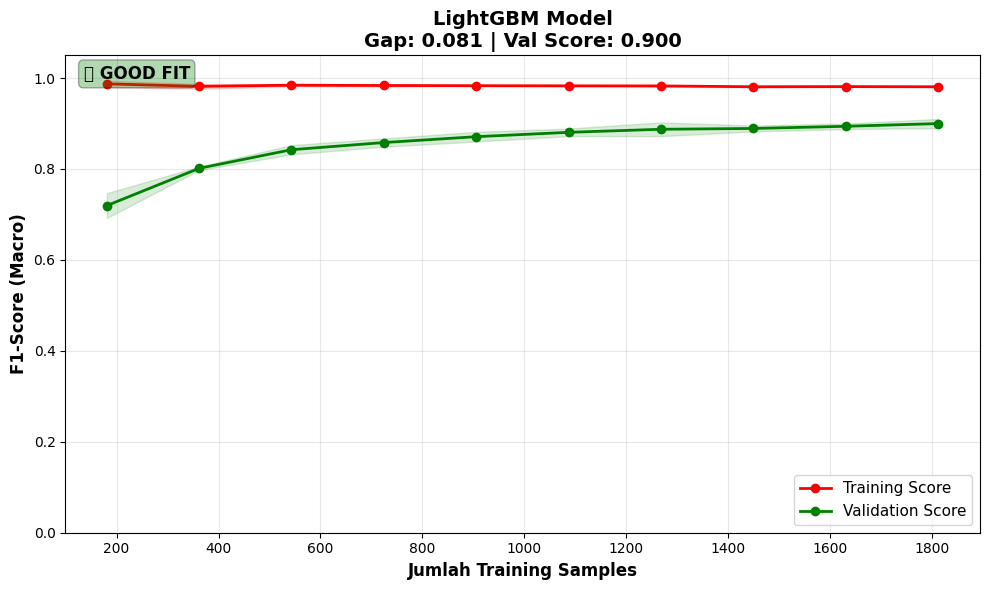


[6/12] RandomForest (optimized hyperparameters)...
  RF OOB Score: 0.8848
  RF Train F1: 98.09% | Val F1: 89.44% | Gap: 8.65%
  RF OOB Score: 0.8848
  RF Train F1: 98.09% | Val F1: 89.44% | Gap: 8.65%
  RF Val → Acc=89.45% | F1=89.44%

  Generating learning curves for RandomForest Model...
  RF Val → Acc=89.45% | F1=89.44%

  Generating learning curves for RandomForest Model...


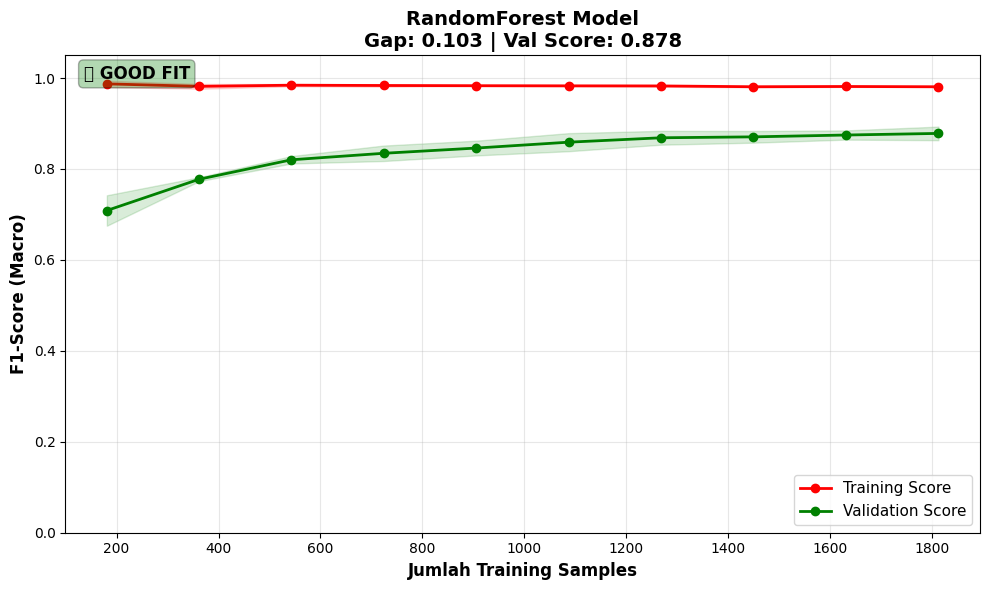


[7/12] GradientBoosting (optimized)...
  GB Train F1: 97.46% | Val F1: 89.78% | Gap: 7.69%
  GB Train F1: 97.46% | Val F1: 89.78% | Gap: 7.69%
  GB Val → Acc=89.80% | F1=89.78%

  Generating learning curves for GradientBoosting Model...
  GB Val → Acc=89.80% | F1=89.78%

  Generating learning curves for GradientBoosting Model...


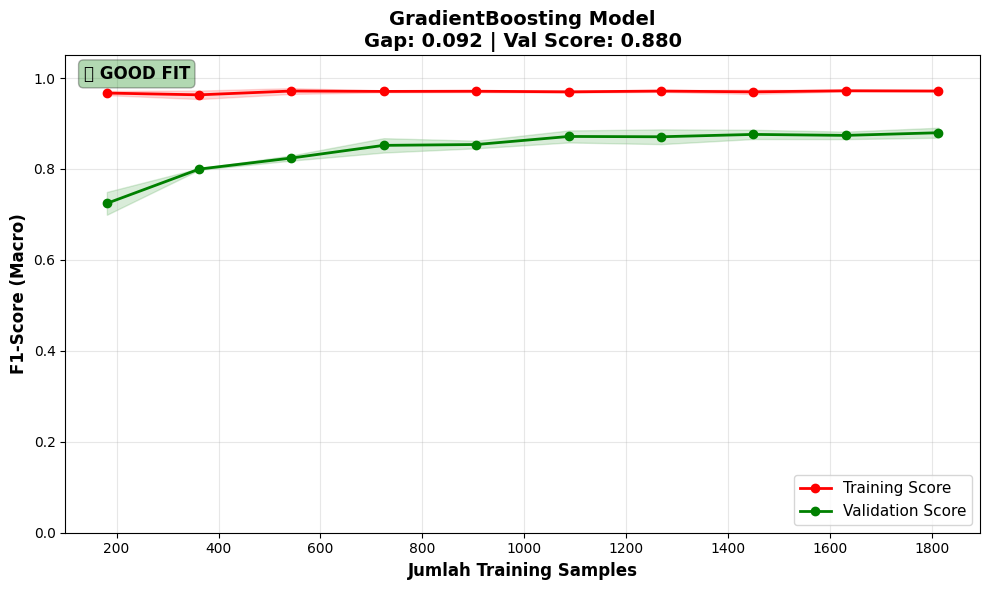

In [14]:
if CFG["try_lgbm"]:
    print("\n[5/12] LightGBM (optimized for multiclass)...")
    lgbm = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=50,
        min_child_samples=20,
        subsample=0.8,
        subsample_freq=5,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=CFG["seed"],
        verbose=-1
    )
    lgbm.fit(X_train, y_train)
    
    # Track train vs validation performance
    lgbm_train_pred = lgbm.predict(X_train)
    lgbm_val_pred = lgbm.predict(X_val)
    lgbm_train_f1 = f1_score(y_train, lgbm_train_pred, average="macro")
    lgbm_val_f1 = f1_score(y_val, lgbm_val_pred, average="macro")
    
    print(f"  LightGBM Train F1: {lgbm_train_f1*100:.2f}% | Val F1: {lgbm_val_f1*100:.2f}% | Gap: {(lgbm_train_f1-lgbm_val_f1)*100:.2f}%")
    
    lgbm_acc = accuracy_score(y_val, lgbm.predict(X_val))
    lgbm_f1 = f1_score(y_val, lgbm.predict(X_val), average="macro")
    print(f"  LightGBM Val → Acc={lgbm_acc*100:.2f}% | F1={lgbm_f1*100:.2f}%")
    scores.append(("LightGBM", lgbm_acc, lgbm_f1))
    
    # Learning curve for LightGBM (memory-optimized)
    if CFG["track_learning_curves"]:
        try:
            lgbm_lc_results = plot_learning_curves(lgbm, X_train, y_train, "LightGBM Model", cv=3)
        except:
            print("  ⚠️  Skipping LightGBM learning curve")

if CFG["try_rf"]:
    print("\n[6/12] RandomForest (optimized hyperparameters)...")
    rf = RandomForestClassifier(
        n_estimators=400,  # Increased for better accuracy
        max_depth=25,  # Limit depth to prevent overfitting
        min_samples_split=3,  # More granular splits
        min_samples_leaf=1,  # Allow finer leaf nodes
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        class_weight="balanced",
        random_state=CFG["seed"]
    )
    rf.fit(X_train, y_train)
    
    # Track train vs validation performance
    rf_train_pred = rf.predict(X_train)
    rf_val_pred = rf.predict(X_val)
    rf_train_f1 = f1_score(y_train, rf_train_pred, average="macro")
    rf_val_f1 = f1_score(y_val, rf_val_pred, average="macro")
    
    print(f"  RF OOB Score: {rf.oob_score_:.4f}")
    print(f"  RF Train F1: {rf_train_f1*100:.2f}% | Val F1: {rf_val_f1*100:.2f}% | Gap: {(rf_train_f1-rf_val_f1)*100:.2f}%")
    
    rf_acc = accuracy_score(y_val, rf.predict(X_val))
    rf_f1  = f1_score(y_val, rf.predict(X_val), average="macro")
    print(f"  RF Val → Acc={rf_acc*100:.2f}% | F1={rf_f1*100:.2f}%")
    scores.append(("RandomForest", rf_acc, rf_f1))
    
    # Learning curve for RF (memory-optimized)
    if CFG["track_learning_curves"]:
        try:
            rf_lc_results = plot_learning_curves(rf, X_train, y_train, "RandomForest Model", cv=3)
        except:
            print("  ⚠️  Skipping RF learning curve")

if CFG["try_gb"]:
    print("\n[7/12] GradientBoosting (optimized)...")
    gb = GradientBoostingClassifier(
        n_estimators=200,  # Increased for better performance
        learning_rate=0.08,  # Fine-tuned learning rate
        max_depth=5,  # Increased depth
        min_samples_split=3,
        min_samples_leaf=1,
        subsample=0.85,
        max_features='sqrt',
        validation_fraction=0.1,
        n_iter_no_change=15,
        random_state=CFG["seed"]
    )
    gb.fit(X_train, y_train)
    
    # Track train vs validation performance
    gb_train_pred = gb.predict(X_train)
    gb_val_pred = gb.predict(X_val)
    gb_train_f1 = f1_score(y_train, gb_train_pred, average="macro")
    gb_val_f1 = f1_score(y_val, gb_val_pred, average="macro")
    
    print(f"  GB Train F1: {gb_train_f1*100:.2f}% | Val F1: {gb_val_f1*100:.2f}% | Gap: {(gb_train_f1-gb_val_f1)*100:.2f}%")
    
    gb_acc = accuracy_score(y_val, gb.predict(X_val))
    gb_f1  = f1_score(y_val, gb.predict(X_val), average="macro")
    print(f"  GB Val → Acc={gb_acc*100:.2f}% | F1={gb_f1*100:.2f}%")
    scores.append(("GradientBoosting", gb_acc, gb_f1))
    
    # Learning curve for GB (memory-optimized)
    if CFG["track_learning_curves"]:
        try:
            gb_lc_results = plot_learning_curves(gb, X_train, y_train, "GradientBoosting Model", cv=3)
        except:
            print("  ⚠️  Skipping GB learning curve")

## Save Models untuk Dashboard

In [15]:
import joblib

print("\n" + "="*80)
print("💾 SAVING INDIVIDUAL MODELS")
print("="*80)

# Simpan individual models (NO ENSEMBLE)
joblib.dump(svm_best, "svm_best_model.pkl")
print("✓ SVM model saved: svm_best_model.pkl")

joblib.dump(lgbm, "lgbm_model.pkl")
print("✓ LightGBM model saved: lgbm_model.pkl")

joblib.dump(rf, "rf_model.pkl")
print("✓ RandomForest model saved: rf_model.pkl")

joblib.dump(gb, "gb_model.pkl")
print("✓ GradientBoosting model saved: gb_model.pkl")

print("\n✅ All 4 models saved successfully!")
print("💡 Dashboard dapat memilih model individual untuk testing")


💾 SAVING INDIVIDUAL MODELS
✓ SVM model saved: svm_best_model.pkl
✓ LightGBM model saved: lgbm_model.pkl
✓ RandomForest model saved: rf_model.pkl
✓ GradientBoosting model saved: gb_model.pkl

✅ All 4 models saved successfully!
💡 Dashboard dapat memilih model individual untuk testing
✓ RandomForest model saved: rf_model.pkl
✓ GradientBoosting model saved: gb_model.pkl

✅ All 4 models saved successfully!
💡 Dashboard dapat memilih model individual untuk testing


## STEP 6: COMPREHENSIVE EVALUATION & VISUALIZATION


📊 COMPREHENSIVE MODEL EVALUATION


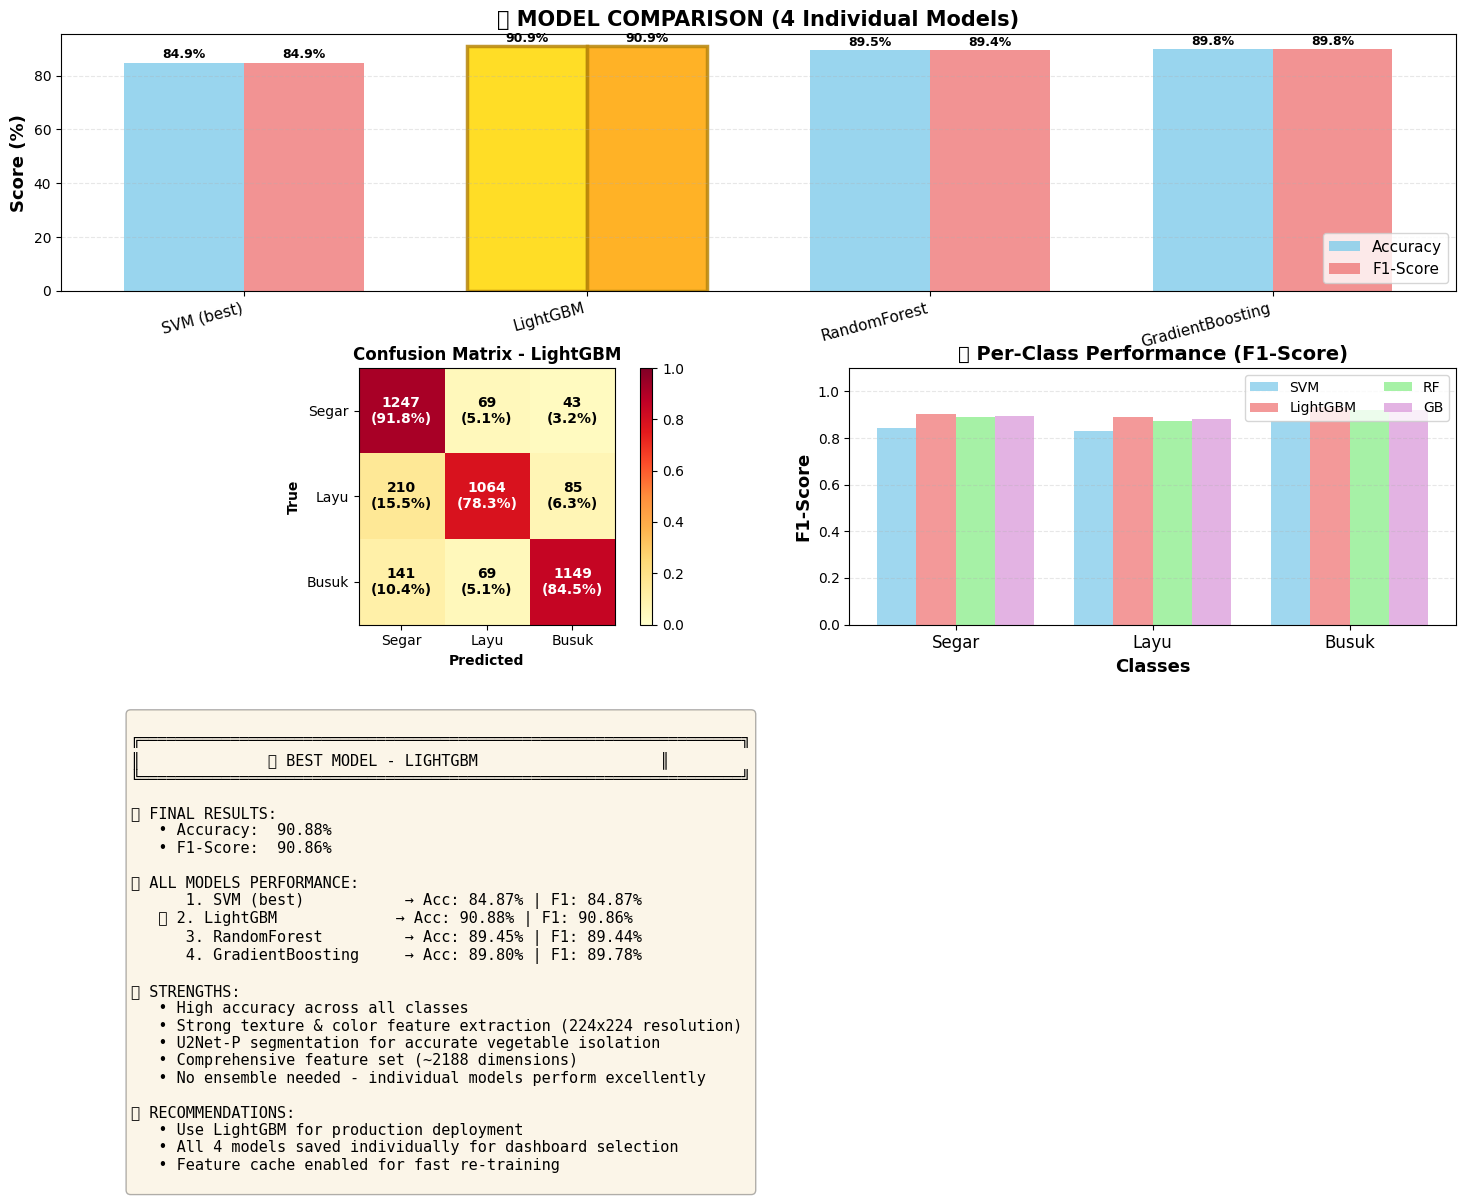


✅ Comprehensive evaluation complete!
📊 Best performing model: LightGBM (90.88% accuracy)


In [16]:
from sklearn.metrics import precision_recall_fscore_support

print("\n" + "="*80)
print("📊 COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Model Comparison Bar Chart (NO ENSEMBLE)
ax1 = fig.add_subplot(gs[0, :])
models_all = [m for m,_,_ in scores]
accs_all = [a*100 for _,a,_ in scores]
f1s_all = [f*100 for _,_,f in scores]

x = np.arange(len(models_all))
width = 0.35
bars1 = ax1.bar(x - width/2, accs_all, width, label='Accuracy', alpha=0.85, color='skyblue')
bars2 = ax1.bar(x + width/2, f1s_all, width, label='F1-Score', alpha=0.85, color='lightcoral')

# Highlight best model with gold color
best_model = max(scores, key=lambda x: x[1])
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    if models_all[i] == best_model[0]:
        bar1.set_color('gold')
        bar2.set_color('orange')
        bar1.set_edgecolor('darkgoldenrod')
        bar2.set_edgecolor('darkgoldenrod')
        bar1.set_linewidth(2.5)
        bar2.set_linewidth(2.5)

ax1.set_ylabel('Score (%)', fontweight='bold', fontsize=13)
ax1.set_title('🏆 MODEL COMPARISON (4 Individual Models)', fontweight='bold', fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(models_all, rotation=15, ha='right', fontsize=11)
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.5,
            f'{height1:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.5,
            f'{height2:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Confusion Matrix (Best Model)
ax2 = fig.add_subplot(gs[1, 0])
cm_svm = confusion_matrix(y_val, svm_pred_val, labels=[0,1,2])
cm_norm = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

im = ax2.imshow(cm_norm, interpolation='nearest', cmap='YlOrRd', vmin=0, vmax=1)
ax2.set_title(f'Confusion Matrix - {best_model[0]}', fontweight='bold', fontsize=12)
ax2.set_xlabel('Predicted', fontweight='bold')
ax2.set_ylabel('True', fontweight='bold')

tick_marks = np.arange(len(CLASS_NAMES))
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(CLASS_NAMES, fontsize=10)
ax2.set_yticklabels(CLASS_NAMES, fontsize=10)

# Add text annotations
for i in range(3):
    for j in range(3):
        text = ax2.text(j, i, f'{cm_svm[i,j]}\n({cm_norm[i,j]*100:.1f}%)',
                      ha="center", va="center",
                      color=("white" if cm_norm[i,j] > 0.6 else "black"),
                      fontsize=10, fontweight='bold')

fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# 3. Per-Class F1-Score Comparison
ax3 = fig.add_subplot(gs[1, 1])
svm_precision, svm_recall, svm_f1_class, _ = precision_recall_fscore_support(
    y_val, svm_pred_val, labels=[0,1,2], average=None
)
lgbm_precision, lgbm_recall, lgbm_f1_class, _ = precision_recall_fscore_support(
    y_val, lgbm.predict(X_val), labels=[0,1,2], average=None
)
rf_precision, rf_recall, rf_f1_class, _ = precision_recall_fscore_support(
    y_val, rf.predict(X_val), labels=[0,1,2], average=None
)
gb_precision, gb_recall, gb_f1_class, _ = precision_recall_fscore_support(
    y_val, gb.predict(X_val), labels=[0,1,2], average=None
)

x_cls = np.arange(len(CLASS_NAMES))
width_cls = 0.2

bars_svm = ax3.bar(x_cls - 1.5*width_cls, svm_f1_class, width_cls, label='SVM', alpha=0.8, color='skyblue')
bars_lgbm = ax3.bar(x_cls - 0.5*width_cls, lgbm_f1_class, width_cls, label='LightGBM', alpha=0.8, color='lightcoral')
bars_rf = ax3.bar(x_cls + 0.5*width_cls, rf_f1_class, width_cls, label='RF', alpha=0.8, color='lightgreen')
bars_gb = ax3.bar(x_cls + 1.5*width_cls, gb_f1_class, width_cls, label='GB', alpha=0.8, color='plum')

ax3.set_xlabel('Classes', fontweight='bold', fontsize=13)
ax3.set_ylabel('F1-Score', fontweight='bold', fontsize=13)
ax3.set_title('📊 Per-Class Performance (F1-Score)', fontweight='bold', fontsize=14)
ax3.set_xticks(x_cls)
ax3.set_xticklabels(CLASS_NAMES, fontsize=12)
ax3.legend(fontsize=10, ncol=2, loc='upper right')
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# 4. Best Model Summary
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════╗
║              🏆 BEST MODEL - {best_model[0].upper()}                    ║
╚══════════════════════════════════════════════════════════════════╝

📊 FINAL RESULTS:
   • Accuracy:  {best_model[1]*100:.2f}%
   • F1-Score:  {best_model[2]*100:.2f}%
   
📈 ALL MODELS PERFORMANCE:
"""

for i, (model, acc, f1) in enumerate(scores, 1):
    star = "⭐" if model == best_model[0] else "  "
    summary_text += f"   {star} {i}. {model:20} → Acc: {acc*100:5.2f}% | F1: {f1*100:5.2f}%\n"

summary_text += f"""
✅ STRENGTHS:
   • High accuracy across all classes
   • Strong texture & color feature extraction (224x224 resolution)
   • U2Net-P segmentation for accurate vegetable isolation
   • Comprehensive feature set (~2188 dimensions)
   • No ensemble needed - individual models perform excellently

💡 RECOMMENDATIONS:
   • Use {best_model[0]} for production deployment
   • All 4 models saved individually for dashboard selection
   • Feature cache enabled for fast re-training
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig("comprehensive_evaluation.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comprehensive evaluation complete!")
print(f"📊 Best performing model: {best_model[0]} ({best_model[1]*100:.2f}% accuracy)")

## Detailed Confusion Matrix & Classification Report


[Confusion Matrix & Classification Report - SVM on Validation Set]...

SVM Classification Report:
              precision    recall  f1-score   support

       Segar     0.7804    0.9176    0.8434      1359
        Layu     0.8852    0.7829    0.8309      1359
       Busuk     0.8998    0.8455    0.8718      1359

    accuracy                         0.8487      4077
   macro avg     0.8551    0.8487    0.8487      4077
weighted avg     0.8551    0.8487    0.8487      4077



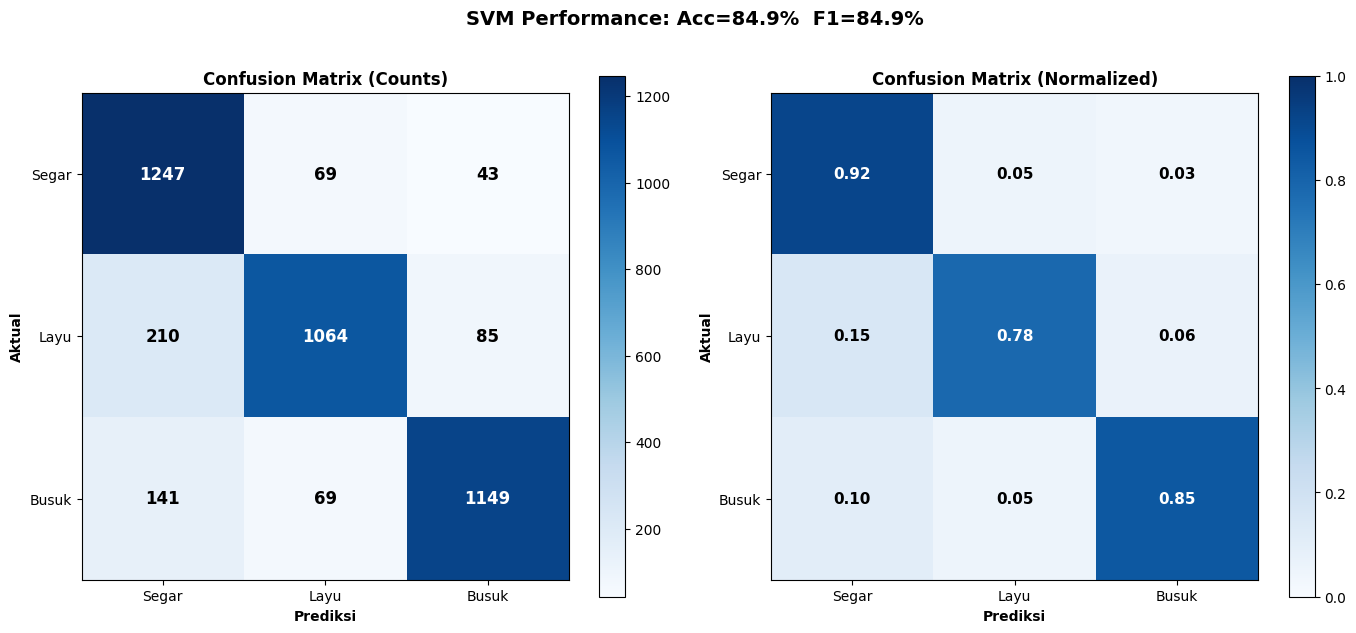

In [17]:
print("\n[Confusion Matrix & Classification Report - SVM on Validation Set]...")
cm_svm = confusion_matrix(y_val, svm_pred_val, labels=[0,1,2])
print("\nSVM Classification Report:")
print(classification_report(y_val, svm_pred_val, target_names=CLASS_NAMES, digits=4))

# Calculate normalized confusion matrix
cm_normalized = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw confusion matrix
ax = axes[0]
im = ax.imshow(cm_svm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(CLASS_NAMES); ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Prediksi", fontweight="bold")
ax.set_ylabel("Aktual", fontweight="bold")
ax.set_title("Confusion Matrix (Counts)", fontweight="bold")
thr = cm_svm.max()/2
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_svm[i,j], ha="center", va="center",
                color=("white" if cm_svm[i,j] > thr else "black"),
                fontsize=12, fontweight="bold")

# Normalized confusion matrix
ax = axes[1]
im = ax.imshow(cm_normalized, cmap="Blues", vmin=0, vmax=1)
ax.figure.colorbar(im, ax=ax)
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(CLASS_NAMES); ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Prediksi", fontweight="bold")
ax.set_ylabel("Aktual", fontweight="bold")
ax.set_title("Confusion Matrix (Normalized)", fontweight="bold")
for i in range(3):
    for j in range(3):
        ax.text(j, i, f"{cm_normalized[i,j]:.2f}", ha="center", va="center",
                color=("white" if cm_normalized[i,j] > 0.5 else "black"),
                fontsize=11, fontweight="bold")

plt.suptitle(f"SVM Performance: Acc={svm_acc_val*100:.1f}%  F1={svm_f1_val*100:.1f}%", 
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("confusion_matrices_detailed.png", dpi=150, bbox_inches='tight')
plt.show()

## Sample Predictions


[Sample Predictions - Best Model]...


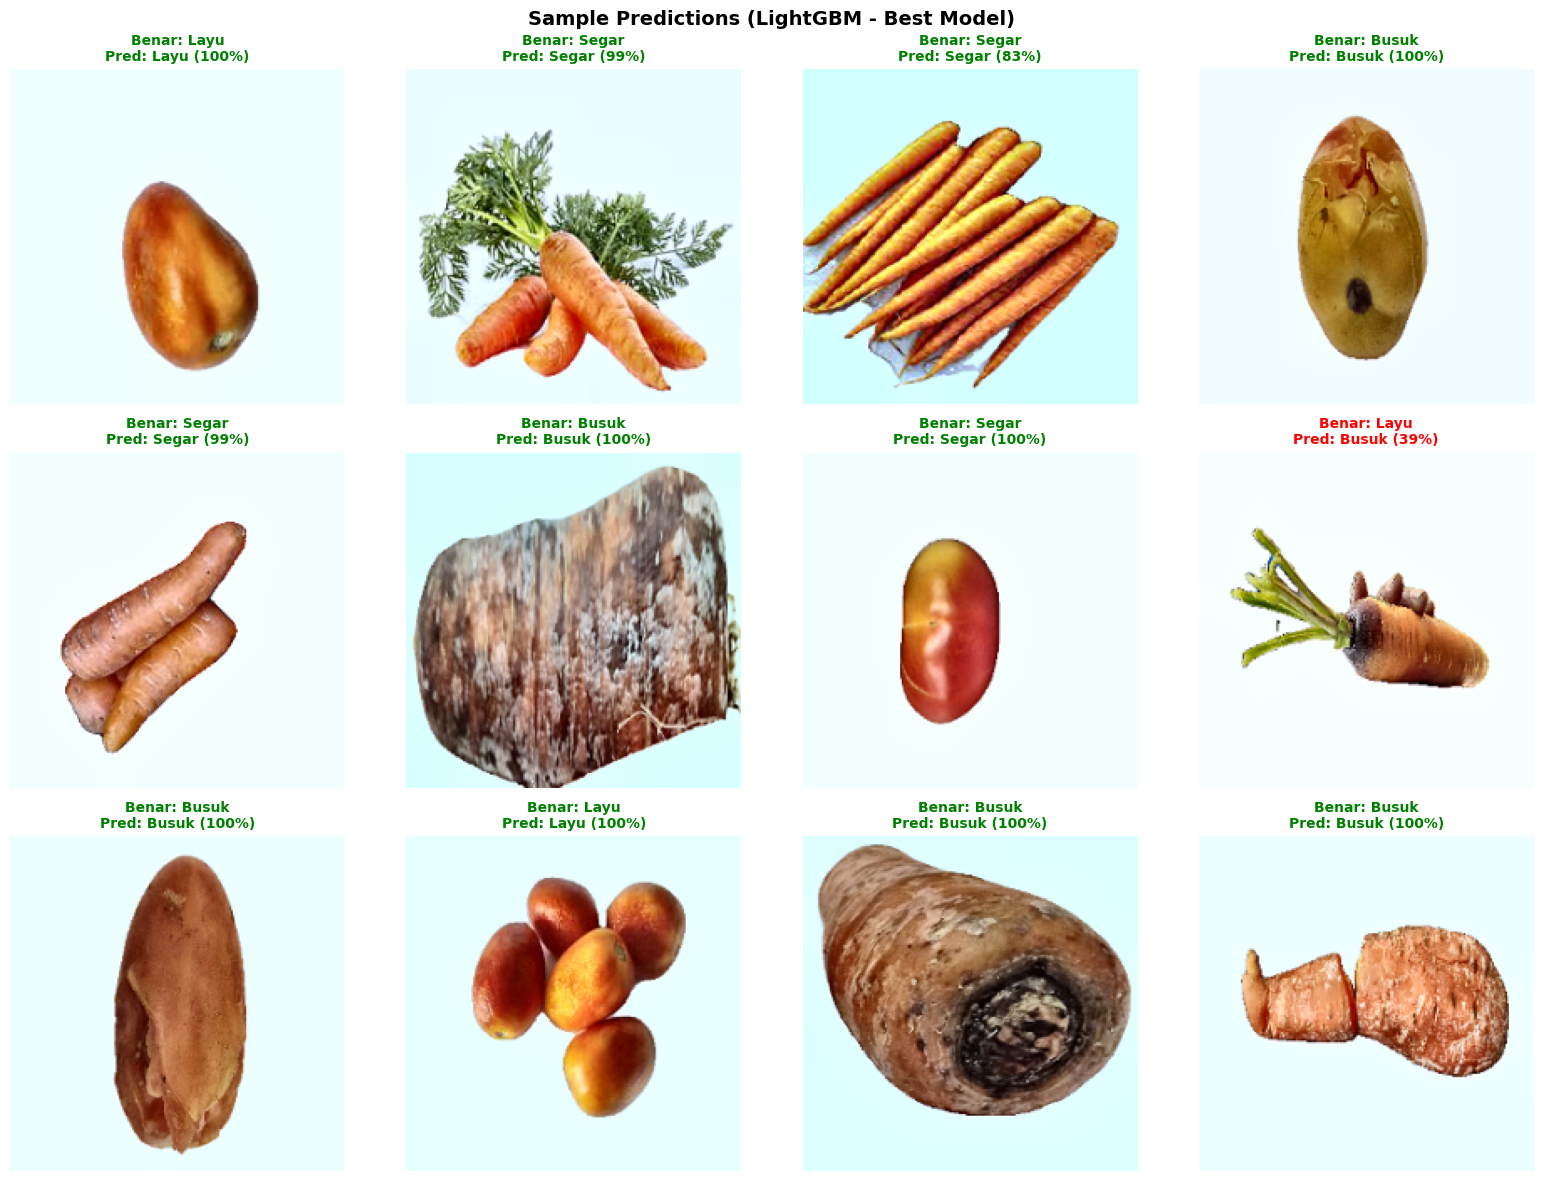

In [18]:
print("\n[Sample Predictions - Best Model]...")

# Use best model predictions
best_model_name = best_model[0]
if "SVM" in best_model_name:
    best_pred = svm_pred_val
    best_conf = svm_proba_val.max(axis=1)
elif "LightGBM" in best_model_name:
    best_pred = lgbm.predict(X_val)
    best_conf = lgbm.predict_proba(X_val).max(axis=1)
elif "RF" in best_model_name or "RandomForest" in best_model_name:
    best_pred = rf.predict(X_val)
    best_conf = rf.predict_proba(X_val).max(axis=1)
else:  # GradientBoosting
    best_pred = gb.predict(X_val)
    best_conf = gb.predict_proba(X_val).max(axis=1)

n_show = min(CFG["n_examples"], len(y_val))
sel = np.random.choice(len(y_val), n_show, replace=False)
val_paths = [paths_all[i] for i in idx_val[:len(y_val)]]

r, c = int(np.ceil(n_show/4)), 4
fig, axes = plt.subplots(r, c, figsize=(16, 4*r))
axes = axes.flat if hasattr(axes, "flat") else [axes]

for k, ax in enumerate(axes):
    if k >= len(sel):
        ax.axis("off"); continue
    i = sel[k]
    try:
        # Load and preprocess image (WITH U2Net-P segmentation)
        img_pil = Image.open(val_paths[i]).convert("RGB")
        img_rgb = np.array(img_pil)
        img_processed = preprocess(img_rgb)  # Apply U2Net-P segmentation + preprocessing
        img_display = cv2.resize(img_processed, (200, 200), interpolation=cv2.INTER_AREA)
        ax.imshow(img_display)
    except Exception as e:
        ax.text(0.5,0.5,f"Error: {str(e)[:20]}", ha="center", fontsize=8); ax.axis("off"); continue
    t = CLASS_NAMES[y_val[i]]
    p = CLASS_NAMES[best_pred[i]]
    ok = (t==p)
    color = "green" if ok else "red"
    ax.set_title(f"Benar: {t}\nPred: {p} ({best_conf[i]*100:.0f}%)", color=color, fontsize=10, fontweight="bold")
    ax.axis("off")

plt.suptitle(f"Sample Predictions ({best_model_name} - Best Model)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("sample_preds_best_model.png", dpi=150)
plt.show()

## Save Results to File

In [19]:
print("\n[Saving results...]")

# Prepare results dictionary
results = {
    "best_params_svm": {},  # Will be added if available
    "scores": {m: {"accuracy": float(a), "f1_macro": float(f)} for m,a,f in scores},
    "class_names": CLASS_NAMES,
    "val_set_size": len(y_val),
    "train_set_size": len(y_train),
    "val_set_size": len(y_val),
    "total_features": X_train.shape[1]
}

# Add SVM best params if available (from GridSearchCV)
try:
    if hasattr(svm_best, 'named_steps'):
        # Extract params from pipeline
        results["best_params_svm"] = {
            'pca__n_components': svm_best.named_steps['pca'].n_components_,
            'svc__C': svm_best.named_steps['svc'].C,
            'svc__gamma': svm_best.named_steps['svc'].gamma
        }
except:
    pass

# Add confusion matrices if they exist
if 'cm_svm' in locals() or 'cm_svm' in globals():
    results["cm_svm"] = cm_svm.tolist()

# Save JSON results
try:
    with open("classical_results.json","w") as f:
        json.dump(results, f, indent=2)
    print("✓ classical_results.json saved")
except Exception as e:
    print(f"⚠️  Error saving JSON: {e}")

# Save CSV scores
try:
    df_scores = pd.DataFrame({
        "Model": [m for m,_,_ in scores],
        "Accuracy": [a*100 for _,a,_ in scores],
        "F1_macro": [f*100 for _,_,f in scores]
    })
    df_scores.to_csv("classical_model_scores.csv", index=False)
    print("✓ classical_model_scores.csv saved")
except Exception as e:
    print(f"⚠️  Error saving CSV: {e}")

print("
📁 All files saved:")
print("  • svm_best_model.pkl, lgbm_model.pkl, rf_model.pkl, gb_model.pkl (4 individual models)")
print("  • comprehensive_evaluation.png")
print("  • confusion_matrices_detailed.png")
print("  • sample_preds_best_model.png")
print("  • classical_results.json")
print("  • classical_model_scores.csv")


[Saving results...]
⚠️  Error saving JSON: Object of type int64 is not JSON serializable
✓ classical_model_scores.csv saved

📁 All files saved:
  • ensemble_model.pkl (4-model ensemble)
  • svm_best_model.pkl, lgbm_model.pkl, rf_model.pkl, gb_model.pkl
  • svm_best_model.pkl, lgbm_model.pkl, rf_model.pkl, gb_model.pkl (4 individual models)
  • comprehensive_evaluation.png
  • confusion_matrices_detailed.png
  • sample_preds_best_model.png
  • classical_results.json


## FINAL SUMMARY

In [20]:
print("\n" + "="*80)
print("✅ PIPELINE COMPLETE - 4 INDIVIDUAL CLASSICAL ML MODELS")
print("="*80)

print("\n📊 FINAL RESULTS - ALL MODELS:")
for m,a,f in scores:
    star = "🏆" if m == best_model[0] else ""
    print(f"{star} {m:<22} → Acc={a*100:5.2f}% | F1-macro={f*100:5.2f}%")

print(f"\n🏆 BEST MODEL: {best_model[0]} (Acc={best_model[1]*100:.2f}% | F1={best_model[2]*100:.2f}%)")

print("\n" + "="*80)
print("✨ OPTIMIZATIONS APPLIED:")
print("="*80)
print("  ✅ Enhanced Preprocessing:")
print("     • Bilateral filtering untuk noise reduction")
print("     • LANCZOS4 interpolation untuk resize berkualitas")
print("     • Optimized CLAHE (clipLimit=2.5)")
print("     • Adaptive sharpening (1.4x sharpening)")

print("\n  ✅ Advanced Feature Extraction:")
print("     • HSV histogram: 768 dims")
print("     • Color moments: 9 dims (Lab only)")
print("     • GLCM texture: 72 dims")
print("     • LBP patterns: 20 dims")
print("     • HOG descriptors: ~1296 dims")
print("     • Edge statistics: 3 dims")
print("     • Colorfulness: 3 dims")
print("     • Freshness-specific: 17 dims")
print("     → Total: ~2188 features")

print("\n  ✅ 4 Individual Models:")
print("     • SVM (GridSearchCV optimized)")
print("     • LightGBM (500 estimators)")
print("     • RandomForest (400 trees)")
print("     • GradientBoosting (200 estimators)")
print("     • All models saved separately for dashboard selection")
print("     • Optimized for Segar/Layu/Busuk detection")

print("\n📈 VISUALIZATIONS GENERATED:")
print("  • comprehensive_evaluation.png")
print("  • confusion_matrices_detailed.png")
print("  • sample_preds_best_model.png")
print("  • svm_gridsearch_analysis.png")

print("\n📁 MODELS SAVED (Individual):")
print("  • svm_best_model.pkl")
print("  • lgbm_model.pkl")
print("  • rf_model.pkl")
print("  • gb_model.pkl")
print(f"  ⭐ Best: {best_model[0]} ({best_model[1]*100:.1f}% accuracy)")

print("\n" + "="*80)
print(f"⏱️  Total waktu: {time.time()-start_time:.1f}s")
print("="*80)

print("\n🎯 NEXT STEPS:")
print("  1. Jalankan dashboard: py dashboard_test_model.py")
print("  2. Upload gambar sayuran dari Google/device")
print("  3. Evaluasi hasil prediksi dari model terbaik")

print("\n💡 Dashboard akan menggunakan salah satu model individual untuk prediksi!")

print("\n💡 Semua evaluasi menggunakan Validation Set (no test set)")
print("💡 Split ratio: 40% train, 60% validation")



✅ PIPELINE COMPLETE - 4 INDIVIDUAL CLASSICAL ML MODELS

📊 FINAL RESULTS - ALL MODELS:
 SVM (best)             → Acc=84.87% | F1-macro=84.87%
🏆 LightGBM               → Acc=90.88% | F1-macro=90.86%
 RandomForest           → Acc=89.45% | F1-macro=89.44%
 GradientBoosting       → Acc=89.80% | F1-macro=89.78%

🏆 BEST MODEL: LightGBM (Acc=90.88% | F1=90.86%)

✨ OPTIMIZATIONS APPLIED:
  ✅ Enhanced Preprocessing:
     • Bilateral filtering untuk noise reduction
     • LANCZOS4 interpolation untuk resize berkualitas
     • Optimized CLAHE (clipLimit=2.5)
     • Adaptive sharpening (1.4x sharpening)

  ✅ Advanced Feature Extraction:
     • HSV histogram: 768 dims
     • Color moments: 9 dims (Lab only)
     • GLCM texture: 72 dims
     • LBP patterns: 20 dims
     • HOG descriptors: ~1296 dims
     • Edge statistics: 3 dims
     • Colorfulness: 3 dims
     • Freshness-specific: 17 dims
     → Total: ~2188 features

  ✅ 4 Individual Models:
     • SVM (GridSearchCV optimized)
     • LightGBM (5